<a href="https://colab.research.google.com/github/ccspen21/greenland-fishery-nowcast-2025/blob/main/model_run_reports.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
repo_dir = "greenland-fishery-nowcast-2025"
if not os.path.exists(repo_dir):
    !git clone https://github.com/ccspen21/greenland-fishery-nowcast-2025.git
else:
    print(f"Directory '{repo_dir}' already exists, skipping clone.")

Cloning into 'greenland-fishery-nowcast-2025'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 73 (delta 38), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (73/73), 594.57 KiB | 4.95 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [2]:
!pip install requests xarray pandas pyjstat datetime pydap netCDF4
import os
import sqlite3
import pandas as pd
import requests
import time as time_module
from pyjstat import pyjstat
from urllib.parse import quote
from io import StringIO
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

!apt-get update && apt-get install -y iputils-ping

DB_PATH = os.getenv("DB_PATH", "greenland_fishery.db")

def validate_dataframe(df, expected_columns, dtypes):
    if df.empty:
        raise ValueError("DataFrame is empty, no rows found.")
    if not all(col in df.columns for col in expected_columns):
        raise ValueError(f"DataFrame missing expected columns: {expected_columns}")
    for col, dtype in dtypes.items():
        if col in df.columns:
            if dtype == int:
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)
            else:
                df[col] = df[col].astype(dtype)
    if df.isnull().any().any():
        raise ValueError(f"DataFrame contains NaN values: {df.head()}")

def fetch_with_retries(url, max_retries=3, timeout=60, method='get', json=None):
    for attempt in range(max_retries):
        try:
            if method == 'get':
                response = requests.get(url, timeout=timeout)
            else:
                response = requests.post(url, json=json, timeout=timeout)
            response.raise_for_status()
            return response
        except requests.exceptions.RequestException as e:
            print(f"Attempt {attempt+1} failed: {e}")
            if attempt + 1 == max_retries:
                raise
            time_module.sleep(2 ** attempt)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.0/798.0 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 380.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.4/115.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 3.3 MB/s eta 0:00:00
  Created wheel for pyjstat: filename=pyjstat-2.4.0-py3-none-any.whl size=22763 sha256=9217f10540937449fffeadde5290c0c4240acb007c43181df40761d4757c7e37
  Stored in director

In [3]:
%cd /content/greenland-fishery-nowcast-2025
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DB_PATH = '/content/drive/MyDrive/greenland_fishery.db'
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()
print(f"Connected to SQLite database at {DB_PATH}")

# Check available tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = [row[0] for row in cursor.fetchall()]
print(f"Available tables: {tables}")

# Verify required tables
required_tables = ['total_catch', 'foreign_catch', 'fish_exports', 'sst_west', 'sst_east', 'sst_south']
if not all(table in tables for table in required_tables):
    missing = [table for table in required_tables if table not in tables]
    raise ValueError(f"Missing tables: {missing}. Ensure setup_dataset.ipynb was run successfully to create the database at {DB_PATH}.")

df_clean = pd.read_sql_query("SELECT * FROM total_catch", conn)
df_foreign_clean = pd.read_sql_query("SELECT * FROM foreign_catch", conn)
df_fish_clean = pd.read_sql_query("SELECT * FROM fish_exports", conn)
df_sst_west_clean = pd.read_sql_query("SELECT * FROM sst_west", conn)
df_sst_east_clean = pd.read_sql_query("SELECT * FROM sst_east", conn)
df_sst_south_clean = pd.read_sql_query("SELECT * FROM sst_south", conn)

expected_columns = {
    'total_catch': ['Year', 'Quarter', 'Total_Catch', 'Unit'],
    'foreign_catch': ['Year', 'Quarter', 'Foreign_Catch', 'Unit'],
    'fish_exports': ['Year', 'Quarter', 'Fish_Export_Value_Million_Kr'],
    'sst_west': ['Year', 'Quarter', 'Sea_Surface_Temp_C_West', 'Melt_Active_West', 'Melt_Index_West'],
    'sst_east': ['Year', 'Quarter', 'Sea_Surface_Temp_C_East', 'Melt_Active_East', 'Melt_Index_East'],
    'sst_south': ['Year', 'Quarter', 'Sea_Surface_Temp_C_South', 'Melt_Active_South', 'Melt_Index_South']
}

dtypes = {
    'Year': int,
    'Quarter': str,
    'Total_Catch': float,
    'Foreign_Catch': float,
    'Fish_Export_Value_Million_Kr': float,
    'Sea_Surface_Temp_C_West': float,
    'Melt_Active_West': int,
    'Melt_Index_West': float,
    'Sea_Surface_Temp_C_East': float,
    'Melt_Active_East': int,
    'Melt_Index_East': float,
    'Sea_Surface_Temp_C_South': float,
    'Melt_Active_South': int,
    'Melt_Index_South': float,
    'Unit': str
}

validate_dataframe(df_clean, expected_columns['total_catch'], dtypes)
validate_dataframe(df_foreign_clean, expected_columns['foreign_catch'], dtypes)
validate_dataframe(df_fish_clean, expected_columns['fish_exports'], dtypes)
validate_dataframe(df_sst_west_clean, expected_columns['sst_west'], dtypes)
validate_dataframe(df_sst_east_clean, expected_columns['sst_east'], dtypes)
validate_dataframe(df_sst_south_clean, expected_columns['sst_south'], dtypes)

print("✅ All DataFrames loaded and validated successfully")

/content/greenland-fishery-nowcast-2025
Mounted at /content/drive
Connected to SQLite database at /content/drive/MyDrive/greenland_fishery.db
Available tables: ['ice_melt_sst', 'total_catch', 'fish_exports', 'sst_west', 'sst_east', 'sst_south', 'foreign_catch']
✅ All DataFrames loaded and validated successfully


In [4]:
# Standardize Year and Quarter columns across all DataFrames
def fix_keys(df):
    df["Year"] = df["Year"].astype(int)
    df["Quarter"] = df["Quarter"].astype(str).str.replace("quarter ", "Q").str.replace("Quarter ", "Q")
    return df

# Apply to all component DataFrames
df_clean = fix_keys(df_clean)
df_fish_clean = fix_keys(df_fish_clean)
df_foreign_clean = fix_keys(df_foreign_clean)
df_sst_west_clean = fix_keys(df_sst_west_clean)
df_sst_east_clean = fix_keys(df_sst_east_clean)
df_sst_south_clean = fix_keys(df_sst_south_clean)

print("✅ Standardized Year and Quarter columns across all DataFrames")

✅ Standardized Year and Quarter columns across all DataFrames


# Time Series of Fish Catch

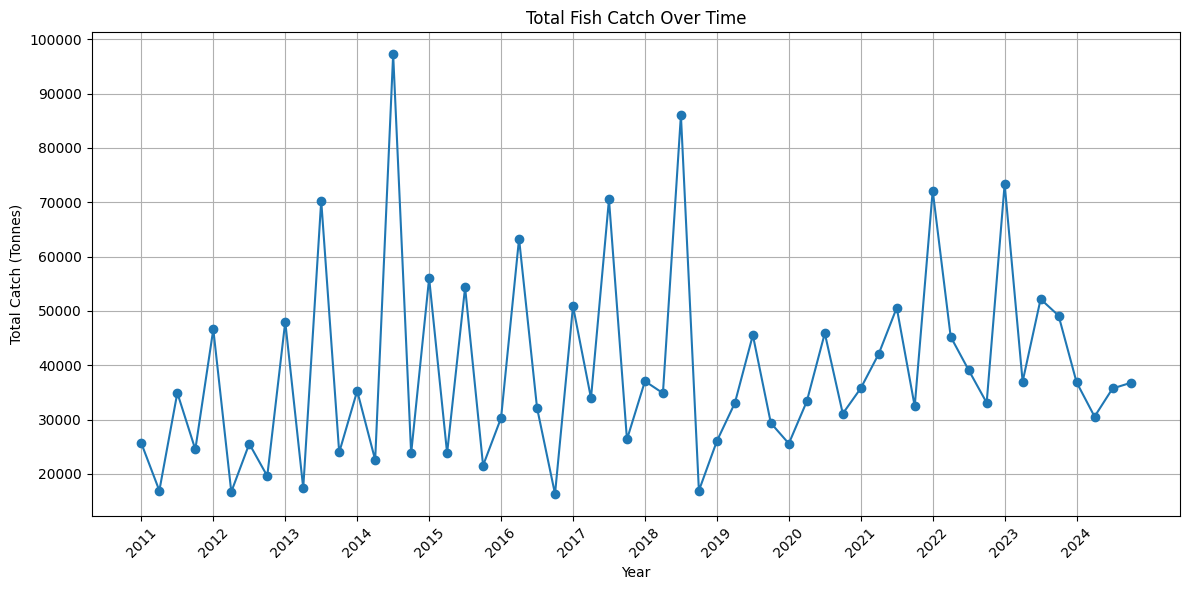

In [5]:
# Time Series of Fish Catch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

df_clean["Time"] = df_clean["Year"].astype(str) + " " + df_clean["Quarter"]
df_clean["Time_Index"] = range(len(df_clean))

# Plot the time series
plt.figure(figsize=(12,6))
plt.plot(df_clean["Time_Index"], df_clean["Total_Catch"], marker='o', linestyle='-')

# Format x-axis: show only one label per year (use Q1 as the anchor)
plt.xticks(
    ticks=df_clean[df_clean["Quarter"] == "Q1"]["Time_Index"],
    labels=df_clean[df_clean["Quarter"] == "Q1"]["Year"],
    rotation=45
)

plt.xlabel("Year")
plt.ylabel("Total Catch (Tonnes)")
plt.title("Total Fish Catch Over Time")
plt.grid(True)
plt.tight_layout()
plt.savefig('total_fish_catch_over_time.png')

# Interaction Term

In [6]:
# Create three-way interaction terms in each SST regional DataFrame
df_sst_west_clean["Melt_SST_Interaction_West"] = (
    df_sst_west_clean["Melt_Active_West"] *
    df_sst_west_clean["Melt_Index_West"] *
    df_sst_west_clean["Sea_Surface_Temp_C_West"]
)

df_sst_east_clean["Melt_SST_Interaction_East"] = (
    df_sst_east_clean["Melt_Active_East"] *
    df_sst_east_clean["Melt_Index_East"] *
    df_sst_east_clean["Sea_Surface_Temp_C_East"]
)

df_sst_south_clean["Melt_SST_Interaction_South"] = (
    df_sst_south_clean["Melt_Active_South"] *
    df_sst_south_clean["Melt_Index_South"] *
    df_sst_south_clean["Sea_Surface_Temp_C_South"]
)

# Merged Dataset

In [7]:
# Merged Dataset
# Start fresh from df_clean
df_merged_with_interactions = df_clean.copy()

# Merge standard right-hand-side variables
df_merged_with_interactions = df_merged_with_interactions.merge(df_fish_clean, on=["Year", "Quarter"], how="inner")

# Merge SST interaction terms
df_merged_with_interactions = df_merged_with_interactions.merge(
    df_sst_west_clean[["Year", "Quarter", "Melt_SST_Interaction_West"]],
    on=["Year", "Quarter"], how="inner"
).merge(
    df_sst_east_clean[["Year", "Quarter", "Melt_SST_Interaction_East"]],
    on=["Year", "Quarter"], how="inner"
).merge(
    df_sst_south_clean[["Year", "Quarter", "Melt_SST_Interaction_South"]],
    on=["Year", "Quarter"], how="inner"
)

# Merge foreign catch
df_merged_with_interactions = df_merged_with_interactions.merge(
    df_foreign_clean.drop(columns=["Unit"]),
    on=["Year", "Quarter"], how="left"
)

# Drop unnecessary columns
df_merged_with_interactions = df_merged_with_interactions.drop(
    columns=[col for col in df_merged_with_interactions.columns if "Unit" in col], errors="ignore"
)
df_merged_with_interactions = df_merged_with_interactions.drop(columns=["Time", "Time_Index"], errors="ignore")

# Order
df_merged_with_interactions["Quarter"] = pd.Categorical(
    df_merged_with_interactions["Quarter"], categories=["Q1", "Q2", "Q3", "Q4"], ordered=True
)
df_merged_with_interactions = df_merged_with_interactions.sort_values(by=["Year", "Quarter"]).reset_index(drop=True)

print("✅ Final merged dataset shape:", df_merged_with_interactions.shape)
display(df_merged_with_interactions.head())

✅ Final merged dataset shape: (56, 8)


,Year,Quarter,Total_Catch,Fish_Export_Value_Million_Kr,Melt_SST_Interaction_West,Melt_SST_Interaction_East,Melt_SST_Interaction_South,Foreign_Catch
0,2011,Q1,25637.0,149.0,0.000000,-0.000000,2.610242,3354.0
1,2011,Q2,16922.0,174.0,0.574115,-0.000000,1.263224,5375.0
2,2011,Q3,34917.0,181.0,5.736561,1.500924,5.861202,78396.0
3,2011,Q4,24504.0,192.0,0.439067,0.197799,4.028882,9673.0
4,2012,Q1,46621.0,133.0,-0.000000,-0.000000,0.675626,2429.0


# Summary Statistics

In [9]:
# Step 1: Identify main (non-lagged) variables
main_vars = [
    col for col in df_merged_with_interactions.columns
    if not col.endswith("_lag1")
    and not col.endswith("_lag2")
    and not col.endswith("_lag3")
    and not col.endswith("_lag4")
    and col not in ["Year", "Quarter"]
]

# Step 2: Subset numeric columns only (optional)
main_df = df_merged_with_interactions[main_vars].select_dtypes(include="number")

# Step 3: Generate descriptive statistics
summary_main = main_df.describe().T
summary_main["missing"] = main_df.isna().sum()
summary_main["skew"] = main_df.skew()
summary_main["kurtosis"] = main_df.kurt()

# Round for cleaner presentation
summary_main = summary_main.round(2)

# Step 4: Display
print("📊 Descriptive Statistics (Main Variables Only):")
display(summary_main)

📊 Descriptive Statistics (Main Variables Only):


,count,mean,std,min,25%,50%,75%,max,missing,skew,kurtosis
Total_Catch,56.0,38844.20,17876.35,16317.00,25622.75,34889.00,46968.75,97235.00,0,1.25,1.53
Fish_Export_Value_Million_Kr,56.0,208.73,79.16,53.00,157.50,199.50,265.00,406.00,0,0.30,-0.27
Melt_SST_Interaction_West,56.0,1.63,2.33,0.00,-0.00,0.46,2.31,6.71,0,1.17,-0.46
Melt_SST_Interaction_East,56.0,0.97,1.61,-0.00,-0.00,0.09,1.34,6.19,0,1.78,2.15
Melt_SST_Interaction_South,56.0,3.02,2.28,0.21,1.00,2.61,4.52,7.75,0,0.52,-1.12
Foreign_Catch,56.0,8312.16,11450.14,309.00,3977.75,6257.00,8962.25,78396.00,0,5.12,28.48


# Correlation Matrix

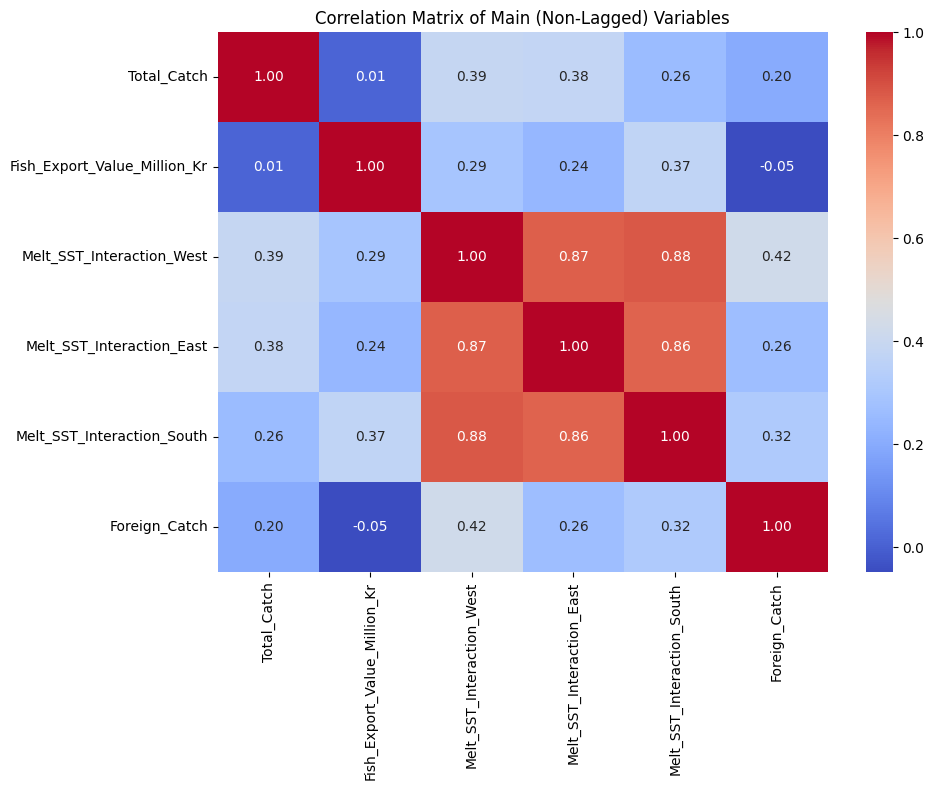

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

main_vars = [
    col for col in df_merged_with_interactions.columns
    if not col.endswith("_lag1") and not col.endswith("_lag2")
    and not col.endswith("_lag3") and not col.endswith("_lag4")
    and col not in ["Year", "Quarter"]
]

main_corr = df_merged_with_interactions[main_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(main_corr, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Correlation Matrix of Main (Non-Lagged) Variables")
plt.tight_layout()
plt.savefig('correlation_matrix.png')

# Nowcasting Q1 2025

In [11]:
# ✅ Use all available data up to Q4 2024
X_train_lasso_q1 = df_model_with_interactions[
    (df_model_with_interactions["Year"] < 2025)
][[
    "Total_Catch_lag4",
    "Melt_SST_Interaction_West_lag4",
    "Foreign_Catch_lag4",
    "Melt_SST_Interaction_East_lag1",
    "Fish_Export_Value_Million_Kr_lag2"
]]

y_train_lasso_q1 = df_model_with_interactions[
    (df_model_with_interactions["Year"] < 2025)
]["Total_Catch"]

# Step 2: Q1 2025 input for LASSO
X_nowcast_lasso_q1 = pd.DataFrame([{
    "Total_Catch_lag4": df_model_with_interactions.iloc[-4]["Total_Catch_lag4"],
    "Melt_SST_Interaction_West_lag4": df_model_with_interactions.iloc[-4]["Melt_SST_Interaction_West_lag4"],
    "Foreign_Catch_lag4": df_model_with_interactions.iloc[-4]["Foreign_Catch_lag4"],
    "Melt_SST_Interaction_East_lag1": df_model_with_interactions.iloc[-1]["Melt_SST_Interaction_East_lag1"],
    "Fish_Export_Value_Million_Kr_lag2": df_model_with_interactions.iloc[-4]["Fish_Export_Value_Million_Kr_lag2"]
}])

# Step 3: LASSO pipeline
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lasso_pipeline_q1 = make_pipeline(
    StandardScaler(),
    Lasso(alpha=1.0, max_iter=10000)
)

lasso_pipeline_q1.fit(X_train_lasso_q1, y_train_lasso_q1)

# Step 4: Predict
y_pred_lasso_q1 = lasso_pipeline_q1.predict(X_nowcast_lasso_q1)[0]
print(f"📈 LASSO Nowcast for Q1 2025: {round(y_pred_lasso_q1):,.0f} tons")

📈 LASSO Nowcast for Q1 2025: 46,205 tons


# Graph of Nowcast

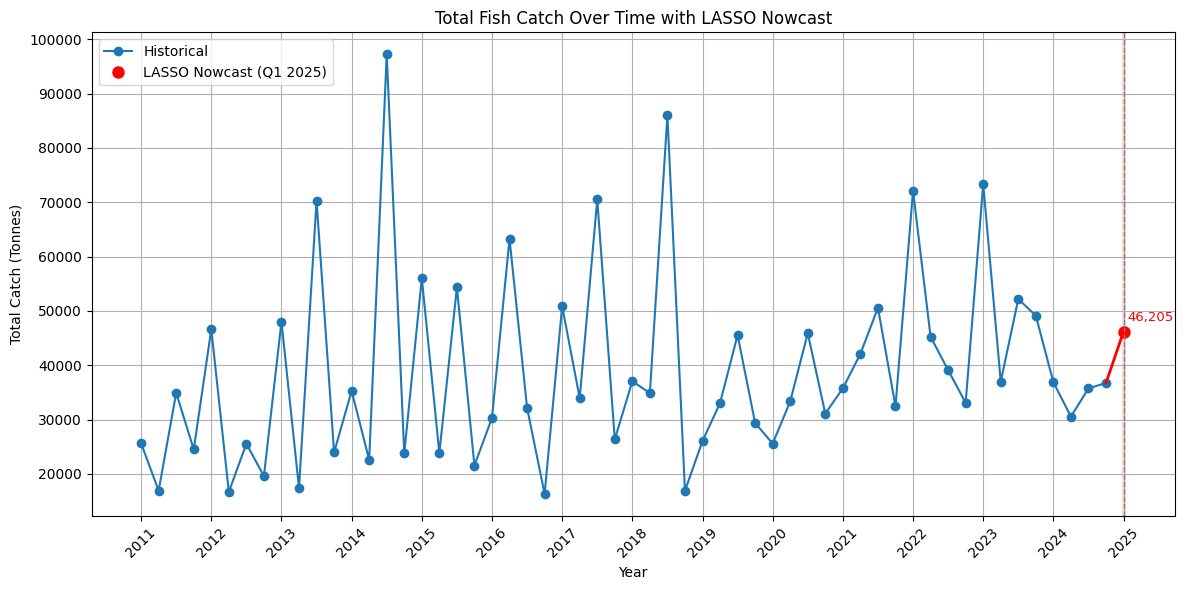

In [12]:
import matplotlib.pyplot as plt

# Rebuild time axis if needed
df_clean["Time"] = df_clean["Year"].astype(str) + " " + df_clean["Quarter"]
df_clean["Time_Index"] = range(len(df_clean))

# Define the index and value for Q4 2024 (last actual) and Q1 2025 (nowcast)
last_actual_index = df_clean["Time_Index"].max()
last_actual_value = df_clean["Total_Catch"].iloc[-1]

nowcast_index = last_actual_index + 1
nowcast_value = y_pred_lasso_q1

# Plot historical series
plt.figure(figsize=(12, 6))
plt.plot(df_clean["Time_Index"], df_clean["Total_Catch"], marker='o', linestyle='-', label="Historical")

# Add red dot for nowcast
plt.plot(nowcast_index, nowcast_value, 'ro', label="LASSO Nowcast (Q1 2025)", markersize=8)

# Add red connecting line from Q4 2024 to Q1 2025
plt.plot([last_actual_index, nowcast_index], [last_actual_value, nowcast_value], color='red', linestyle='-', linewidth=2)

# Update x-ticks to include 2025
xticks = list(df_clean[df_clean["Quarter"] == "Q1"]["Time_Index"])
xticks_labels = list(df_clean[df_clean["Quarter"] == "Q1"]["Year"].astype(str))
xticks.append(nowcast_index)
xticks_labels.append("2025")

plt.xticks(ticks=xticks, labels=xticks_labels, rotation=45)

plt.text(
    nowcast_index + 0.2,          # shift right
    nowcast_value + 2000,         # shift upward
    f"{round(nowcast_value):,}",
    color="red",
    fontsize=9.5,
)

plt.axvspan(nowcast_index - 0.1, nowcast_index + 0.1, color='red', alpha=0.1)

plt.axvline(nowcast_index, color='gray', linestyle='--', linewidth=1)

# Labels and formatting
plt.xlabel("Year")
plt.ylabel("Total Catch (Tonnes)")
plt.title("Total Fish Catch Over Time with LASSO Nowcast")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('total_fish_catch_with_nowcast.png')

# Capelin Dummy - Example of Policy Intervention

Note on Capelin Dummy
The Capelin_Open dummy variable is introduced here to model the impact of policy interventions (e.g., fishery closures in 2019, 2020, 2024, and 2025). This variable is used specifically for nowcasting in this notebook and is not included in the LASSO model fitting performed in model_fitting_diagnostics.ipynb. This allows us to isolate the effect of policy shocks in our nowcast analysis.


In [13]:
# Add Capelin_Open dummy variable to the existing df_model_with_interactions
df_model_capelin = df_model_with_interactions.copy()

# Add Capelin_Open dummy variable
df_model_capelin["Capelin_Open"] = df_model_capelin["Year"].apply(
    lambda x: 0 if x in [2019, 2020, 2024, 2025] else 1
)

# Define target and features (include Capelin_Open)
y_capelin = df_model_capelin["Total_Catch"]
X_capelin = df_model_capelin[
    [
        "Total_Catch_lag4",
        "Foreign_Catch_lag4",
        "Melt_SST_Interaction_West_lag4",
        "Melt_SST_Interaction_East_lag1",
        "Fish_Export_Value_Million_Kr_lag2",
        "Capelin_Open"
    ]
]

# Final check
print("✅ X_capelin shape:", X_capelin.shape)
print("✅ y_capelin shape:", y_capelin.shape)
print("✅ Final predictors:", X_capelin.columns.tolist())

✅ X_capelin shape: (52, 6)
✅ y_capelin shape: (52,)
✅ Final predictors: ['Total_Catch_lag4', 'Foreign_Catch_lag4', 'Melt_SST_Interaction_West_lag4', 'Melt_SST_Interaction_East_lag1', 'Fish_Export_Value_Million_Kr_lag2', 'Capelin_Open']


# Nowcast with Capelin Dummy

In [14]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Step 1: Training data (up to Q4 2024)
X_train_q1_2025_binary = df_model_capelin[
    (df_model_capelin["Year"] < 2025)
][[
    "Total_Catch_lag4",
    "Foreign_Catch_lag4",
    "Melt_SST_Interaction_West_lag4",
    "Melt_SST_Interaction_East_lag1",
    "Fish_Export_Value_Million_Kr_lag2",
    "Capelin_Open"
]]
y_train_q1_2025_binary = df_model_capelin[
    (df_model_capelin["Year"] < 2025)
]["Total_Catch"]

print("✅ Training set size with Capelin dummy:", X_train_q1_2025_binary.shape)

# Step 2: Input row for Q1 2025
X_nowcast_q1_2025_binary = pd.DataFrame([{
    "Total_Catch_lag4": df_model_capelin.iloc[-4]["Total_Catch_lag4"],
    "Foreign_Catch_lag4": df_model_capelin.iloc[-4]["Foreign_Catch_lag4"],
    "Melt_SST_Interaction_West_lag4": df_model_capelin.iloc[-4]["Melt_SST_Interaction_West_lag4"],
    "Melt_SST_Interaction_East_lag1": df_model_capelin.iloc[-1]["Melt_SST_Interaction_East_lag1"],
    "Fish_Export_Value_Million_Kr_lag2": df_model_capelin.iloc[-4]["Fish_Export_Value_Million_Kr_lag2"],
    "Capelin_Open": 0  # manually set to 0 because 2025 is closed
}])

print("✅ Nowcast input for Q1 2025 with Capelin dummy:")
display(X_nowcast_q1_2025_binary)

# Step 3: Lasso model pipeline
lasso_pipeline_q1_binary = make_pipeline(
    StandardScaler(),
    Lasso(alpha=1.0, max_iter=50000, random_state=42)
)

# Step 4: Fit and predict
lasso_pipeline_q1_binary.fit(X_train_q1_2025_binary, y_train_q1_2025_binary)
y_pred_q1_2025_binary = lasso_pipeline_q1_binary.predict(X_nowcast_q1_2025_binary)[0]

# Step 5: Output result
print(f"📈 📊 Lasso Nowcast for Q1 2025 (with Capelin dummy): {round(y_pred_q1_2025_binary):,.0f} tons")

✅ Training set size with Capelin dummy: (52, 6)
✅ Nowcast input for Q1 2025 with Capelin dummy:


,Total_Catch_lag4,Foreign_Catch_lag4,Melt_SST_Interaction_West_lag4,Melt_SST_Interaction_East_lag1,Fish_Export_Value_Million_Kr_lag2,Capelin_Open
0,73337.0,4572.0,-0.0,0.664484,322.0,0


📈 📊 Lasso Nowcast for Q1 2025 (with Capelin dummy): 41,426 tons


## Graph Comparison of Nowcasts

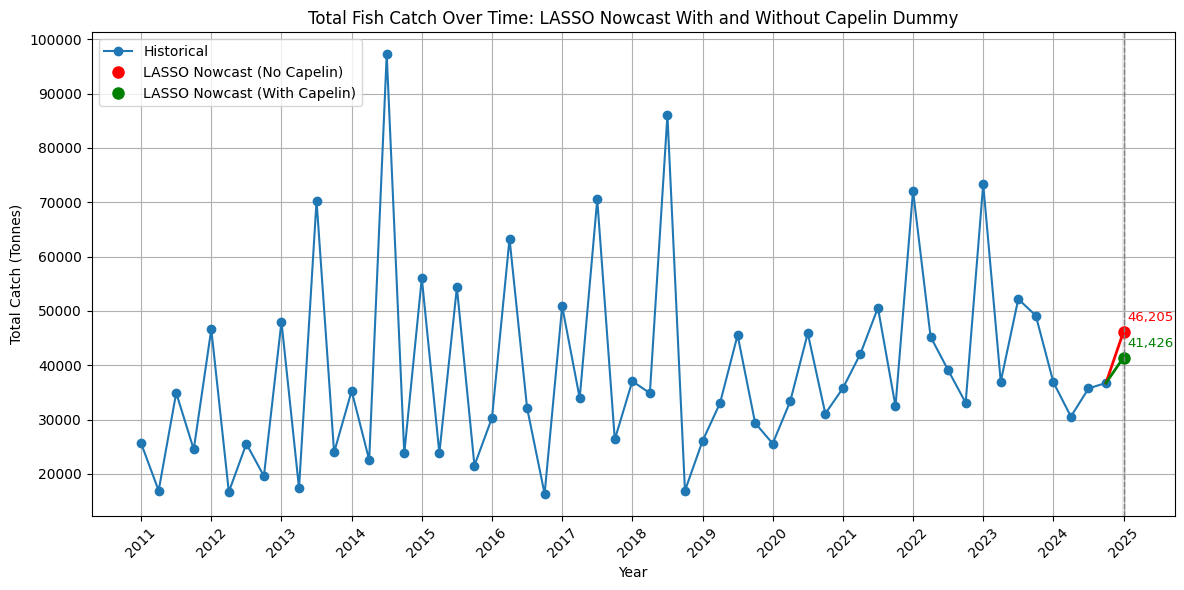

In [15]:
import matplotlib.pyplot as plt

# Rebuild time axis if needed
df_clean["Time"] = df_clean["Year"].astype(str) + " " + df_clean["Quarter"]
df_clean["Time_Index"] = range(len(df_clean))

# Final observed point (Q4 2024)
last_actual_index = df_clean["Time_Index"].max()
last_actual_value = df_clean["Total_Catch"].iloc[-1]

# Prediction point (Q1 2025)
nowcast_index = last_actual_index + 1
nowcast_std = y_pred_lasso_q1                 # Standard LASSO (no Capelin)
nowcast_binary = y_pred_q1_2025_binary        # LASSO with Capelin dummy

# Plot historical data
plt.figure(figsize=(12, 6))
plt.plot(df_clean["Time_Index"], df_clean["Total_Catch"], marker='o', linestyle='-', label="Historical")

# Plot both nowcasts as dots
plt.plot(nowcast_index, nowcast_std, 'ro', label="LASSO Nowcast (No Capelin)", markersize=8)
plt.plot(nowcast_index, nowcast_binary, 'go', label="LASSO Nowcast (With Capelin)", markersize=8)

# Connect last actual to each forecast
plt.plot([last_actual_index, nowcast_index], [last_actual_value, nowcast_std],
         color='red', linestyle='-', linewidth=2)
plt.plot([last_actual_index, nowcast_index], [last_actual_value, nowcast_binary],
         color='green', linestyle='-', linewidth=2)

# Annotate both nowcast values
plt.text(nowcast_index + 0.2, nowcast_std + 2000,
         f"{round(nowcast_std):,}", color="red", fontsize=9.5)

plt.text(nowcast_index + 0.2, nowcast_binary + 2000,
         f"{round(nowcast_binary):,}", color="green", fontsize=9.5)

# Forecast area shading and vertical marker
plt.axvspan(nowcast_index - 0.1, nowcast_index + 0.1, color='gray', alpha=0.1)
plt.axvline(nowcast_index, color='gray', linestyle='--', linewidth=1)

# X-axis setup
xticks = list(df_clean[df_clean["Quarter"] == "Q1"]["Time_Index"])
xticks_labels = list(df_clean[df_clean["Quarter"] == "Q1"]["Year"].astype(str))
xticks.append(nowcast_index)
xticks_labels.append("2025")
plt.xticks(ticks=xticks, labels=xticks_labels, rotation=45)

# Labels and formatting
plt.xlabel("Year")
plt.ylabel("Total Catch (Tonnes)")
plt.title("Total Fish Catch Over Time: LASSO Nowcast With and Without Capelin Dummy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('nowcast_comparison.png')

# Actual vs. Predicted Plot for Backtests

<ipython-input-19-eb28deef6af7>:38: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-19-eb28deef6af7>:39: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig('actual_vs_predicted.png')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


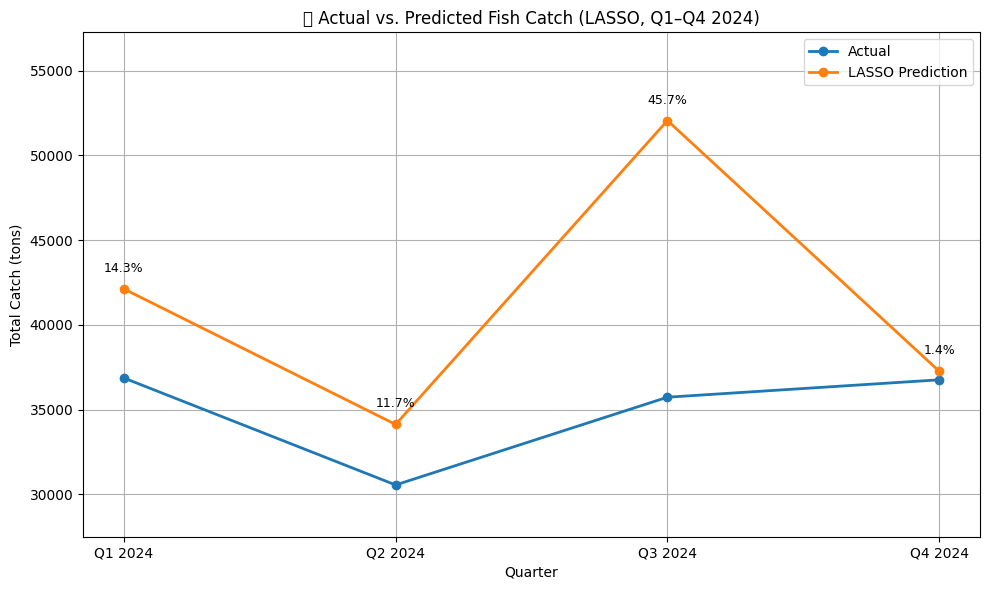

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Load backtest results
backtest_results = pd.read_csv('/content/drive/MyDrive/backtest_results_2024.csv')

quarters = backtest_results["Quarter"].tolist()
actual_values = backtest_results["Actual"].tolist()
predicted_values = backtest_results["Predicted"].tolist()

# Calculate absolute percentage error
percentage_errors = [
    abs((pred - actual) / actual) * 100 if actual != 0 else None
    for pred, actual in zip(predicted_values, actual_values)
]

# For y-axis limits
all_values = actual_values + predicted_values
y_min = min(all_values) * 0.9
y_max = max(all_values) * 1.1

# Plot
plt.figure(figsize=(10, 6))
plt.plot(quarters, actual_values, label="Actual", marker='o', linewidth=2)
plt.plot(quarters, predicted_values, label="LASSO Prediction", marker='o', linewidth=2)

# Annotate % errors
for i, (qtr, pred, error) in enumerate(zip(quarters, predicted_values, percentage_errors)):
    if error is not None:
        plt.text(i, pred + 1000, f"{error:.1f}%", color="black", fontsize=9, ha='center')

plt.ylim(y_min, y_max)
plt.title("📊 Actual vs. Predicted Fish Catch (LASSO, Q1–Q4 2024)")
plt.xlabel("Quarter")
plt.ylabel("Total Catch (tons)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('actual_vs_predicted.png')
plt.show()


In [17]:
# Close the database connection
try:
    conn.close()
    print("Database connection closed.")
except Exception as e:
    print(f"Error closing database connection: {e}")

Database connection closed.
